Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/nin-cifar10_filter-response-norm.ipynb)

## Code Modules, Classes, & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
import sklearn.preprocessing as skp
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i])\
                      .reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:5]))
    print('^'.join('%12s'%classes[labels[j]] 
                   for j in range(5)),end='^')

In [4]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [5]:
img_size=32
random_seed=12; batch_size=256
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5); tr1=(.48,.48,.48)
train_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/cifar-10-python.tar.gz to data


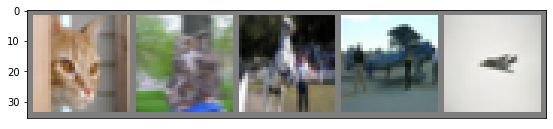

         cat^        bird^       horse^       plane^       plane^

In [6]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes)

In [7]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
print(x.mean(),x.std())
#x=skp.MinMaxScaler((.05,.9))\
#.fit_transform(x.reshape(-1,img_size*img_size*3))
x=x.reshape(-1,3,img_size,img_size)
#print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

['backgrounds', 'images', 'labels']
0.5900519 0.1395963


In [8]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

Image dimensions: torch.Size([128, 3, 32, 32])
Label dimensions: torch.Size([128])


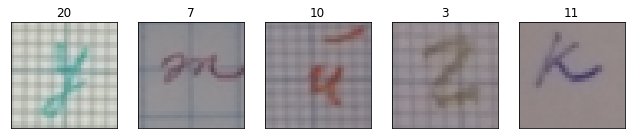

In [9]:
display_examples(valid_loader2,img_size)

## Filter Response Normalization for NNinNN

In [10]:
class FilterResponseNorm(tnn.Module):
    def __init__(self,num_features,eps=1e-6):
        super(FilterResponseNorm,self).__init__()        
        self.register_parameter('beta',\
        tnn.Parameter(torch.empty([1,num_features,1,1]).normal_()))
        self.register_parameter('gamma',\
        tnn.Parameter(torch.empty([1,num_features,1,1]).normal_()))      
        self.register_parameter('tau',\
        tnn.Parameter(torch.empty([1,num_features,1,1]).normal_()))     
        self.eps=torch.Tensor([eps])
    def forward(self,x):
        n,c,h,w=x.size()        
        self.eps=self.eps.to(self.tau.device)
        nu2=torch.mean(x.pow(2),(2,3),keepdims=True)
        x=x*torch.rsqrt(nu2+torch.abs(self.eps))
        return torch.max(self.gamma*x+self.beta,self.tau)

In [11]:
def convfrn(x,y,k,s,p):
    return tnn.Sequential(
        tnn.Conv2d(x,y,kernel_size=k,
                   stride=s,padding=p),\
        FilterResponseNorm(y))

In [12]:
class FRN_NNinNN(tnn.Module):
    def __init__(self,num_classes):
        super(FRN_NNinNN,self).__init__()
        self.num_classes=num_classes
        self.classifier=tnn.Sequential(
            convfrn(3,192,5,1,2),
            convfrn(192,160,1,1,0),
            convfrn(160,96,1,1,0),
            tnn.MaxPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convfrn(96,192,5,1,2),
            convfrn(192,192,1,1,0),
            convfrn(192,192,1,1,0),
            tnn.AvgPool2d(kernel_size=3,
                          stride=2,padding=1),
            tnn.Dropout(.5),
            convfrn(192,192,3,1,1),
            convfrn(192,192,1,1,0),
            tnn.Conv2d(192,self.num_classes,
                       kernel_size=1,stride=1,padding=0),
            tnn.ReLU(),
            tnn.AvgPool2d(kernel_size=8,
                          stride=1,padding=0))
    def forward(self,x):
        x=self.classifier(x)
        logits=x.view(x.size(0),self.num_classes)
        probs=torch.softmax(logits,dim=1)
        return logits,probs

## Training

In [13]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval() # the optional row
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [14]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.00005
model=FRN_NNinNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [15]:
%train_run 200

Epoch: 001/200 | Batch 000/171 | Cost: 2.3489
Epoch: 001/200 | Batch 100/171 | Cost: 2.3026
Epoch: 001/200 train acc: 16.35% valid acc: 16.00%
Epoch: 002/200 | Batch 000/171 | Cost: 2.2836
Epoch: 002/200 | Batch 100/171 | Cost: 2.2115
Epoch: 002/200 train acc: 22.83% valid acc: 21.93%
Epoch: 003/200 | Batch 000/171 | Cost: 2.1547
Epoch: 003/200 | Batch 100/171 | Cost: 2.1400
Epoch: 003/200 train acc: 21.83% valid acc: 21.60%
Epoch: 004/200 | Batch 000/171 | Cost: 2.1234
Epoch: 004/200 | Batch 100/171 | Cost: 2.1093
Epoch: 004/200 train acc: 22.67% valid acc: 22.02%
Epoch: 005/200 | Batch 000/171 | Cost: 2.1605
Epoch: 005/200 | Batch 100/171 | Cost: 2.0977
Epoch: 005/200 train acc: 25.66% valid acc: 25.40%
Epoch: 006/200 | Batch 000/171 | Cost: 2.0658
Epoch: 006/200 | Batch 100/171 | Cost: 2.0555
Epoch: 006/200 train acc: 27.65% valid acc: 27.78%
Epoch: 007/200 | Batch 000/171 | Cost: 2.0588
Epoch: 007/200 | Batch 100/171 | Cost: 2.0976
Epoch: 007/200 train acc: 27.51% valid acc: 27.58%

In [16]:
%print_acc 1

Train accuracy: 51.6409%
Valid accuracy: 46.7000%
Test accuracy: 46.4900%


In [17]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer2.zero_grad(); cost.backward()
            optimizer2.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))


In [18]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.00005
model=FRN_NNinNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [ ]:
%train_run2 300

Epoch: 001/300 | Batch 000/088 | Cost: 3.5229
Epoch: 001/300 | Batch 050/088 | Cost: 3.4935
Epoch: 001/300 train acc: 3.17% valid acc: 2.89%
Epoch: 002/300 | Batch 000/088 | Cost: 3.5005
Epoch: 002/300 | Batch 050/088 | Cost: 3.4919
Epoch: 002/300 train acc: 3.16% valid acc: 2.82%
Epoch: 003/300 | Batch 000/088 | Cost: 3.4965
Epoch: 003/300 | Batch 050/088 | Cost: 3.4984
Epoch: 003/300 train acc: 4.49% valid acc: 3.38%
Epoch: 004/300 | Batch 000/088 | Cost: 3.4958
Epoch: 004/300 | Batch 050/088 | Cost: 3.4914
Epoch: 004/300 train acc: 5.16% valid acc: 5.00%
Epoch: 005/300 | Batch 000/088 | Cost: 3.4920
Epoch: 005/300 | Batch 050/088 | Cost: 3.4878
Epoch: 005/300 train acc: 5.29% valid acc: 4.79%
Epoch: 006/300 | Batch 000/088 | Cost: 3.4812
Epoch: 006/300 | Batch 050/088 | Cost: 3.4592
Epoch: 006/300 train acc: 6.16% valid acc: 5.43%
Epoch: 007/300 | Batch 000/088 | Cost: 3.4840
Epoch: 007/300 | Batch 050/088 | Cost: 3.4498
Epoch: 007/300 train acc: 6.59% valid acc: 6.06%
Epoch: 008/30

In [ ]:
%print_acc 2